In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import argparse
import sys
import time
import copy

import numpy as np

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem.Crippen import MolLogP

from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable

#from utils import read_ZINC_smiles, smiles_to_onehot, partition, OneHotLogPDataSet
from tqdm import tnrange, tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
paser = argparse.ArgumentParser()
args = paser.parse_args("")
args.seed = 123
args.val_size = 0.1
args.test_size = 0.1
args.shuffle = True

In [5]:
np.random.seed(args.seed)
torch.manual_seed(args.seed)

## 1. Pre-Processing

In [6]:
def read_ZINC_smiles(file_name, num_mol):
    f = open(file_name, 'r')
    contents = f.readlines()

    smi_list = []
    logP_list = []

    for i in tqdm_notebook(range(num_mol), desc='Reading Data'):
        smi = contents[i].strip()
        m = Chem.MolFromSmiles(smi)
        smi_list.append(smi)
        logP_list.append(MolLogP(m))

    logP_list = np.asarray(logP_list).astype(float)

    return smi_list, logP_list


def smiles_to_onehot(smi_list):
    def smiles_to_vector(smiles, vocab, max_length):
        while len(smiles) < max_length:
            smiles += " "
        vector = [vocab.index(str(x)) for x in smiles]
        one_hot = np.zeros((len(vocab), max_length), dtype=int)
        for i, elm in enumerate(vector):
            one_hot[elm][i] = 1
        return one_hot

    vocab = np.load('./vocab.npy')
    smi_total = []

    for i, smi in tqdm_notebook(enumerate(smi_list), desc='Converting to One Hot'):
        smi_onehot = smiles_to_vector(smi, list(vocab), 120)
        smi_total.append(smi_onehot)

    return np.asarray(smi_total)

def convert_to_graph(smiles_list):
    adj = []
    adj_norm = []
    features = []
    maxNumAtoms = 50
    for i in tqdm_notebook(smiles_list, desc='Converting to Graph'):
        # Mol
        iMol = Chem.MolFromSmiles(i.strip())
        #Adj
        iAdjTmp = Chem.rdmolops.GetAdjacencyMatrix(iMol)
        # Feature
        if( iAdjTmp.shape[0] <= maxNumAtoms):
            # Feature-preprocessing
            iFeature = np.zeros((maxNumAtoms, 58))
            iFeatureTmp = []
            for atom in iMol.GetAtoms():
                iFeatureTmp.append( atom_feature(atom) ) ### atom features only
            iFeature[0:len(iFeatureTmp), 0:58] = iFeatureTmp ### 0 padding for feature-set
            features.append(iFeature)

            # Adj-preprocessing
            iAdj = np.zeros((maxNumAtoms, maxNumAtoms))
            iAdj[0:len(iFeatureTmp), 0:len(iFeatureTmp)] = iAdjTmp + np.eye(len(iFeatureTmp))
            adj.append(np.asarray(iAdj))
    features = np.asarray(features)

    return features, adj
    
def atom_feature(atom):
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                      ['C', 'N', 'O', 'S', 'F', 'H', 'Si', 'P', 'Cl', 'Br',
                                       'Li', 'Na', 'K', 'Mg', 'Ca', 'Fe', 'As', 'Al', 'I', 'B',
                                       'V', 'Tl', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn',
                                       'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'Mn', 'Cr', 'Pt', 'Hg', 'Pb']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5]) +
                    [atom.GetIsAromatic()])    # (40, 6, 5, 6, 1)

def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        raise Exception("input {0} not in allowable set{1}:".format(x, allowable_set))
    #print list((map(lambda s: x == s, allowable_set)))
    return list(map(lambda s: x == s, allowable_set))

def one_of_k_encoding_unk(x, allowable_set):
    """Maps inputs not in the allowable set to the last element."""
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


class GCNDataset(Dataset):
    def __init__(self, list_feature, list_adj, list_logP):
        self.list_feature = list_feature
        self.list_adj = list_adj
        self.list_logP = list_logP

    def __len__(self):
        return len(self.list_feature)

    def __getitem__(self, index):
        return self.list_feature[index], self.list_adj[index], self.list_logP[index]


def partition(list_feature, list_adj, list_logP, args):
    num_total = list_feature.shape[0]
    num_train = int(num_total * (1 - args.test_size - args.val_size))
    num_val = int(num_total * args.val_size)
    num_test = int(num_total * args.test_size)

    feature_train = list_feature[:num_train]
    adj_train = list_adj[:num_train]
    logP_train = list_logP[:num_train]
    feature_val = list_feature[num_train:num_train + num_val]
    adj_val = list_adj[num_train:num_train + num_val]
    logP_val = list_logP[num_train:num_train + num_val]
    feature_test = list_feature[num_total - num_test:]
    adj_test = list_adj[num_train:num_train + num_val]
    logP_test = list_logP[num_total - num_test:]

    train_set = GCNDataset(feature_train, adj_train, logP_train)
    val_set = GCNDataset(feature_val, adj_val, logP_val)
    test_set = GCNDataset(feature_test, adj_test, logP_test)

    partition = {
        'train': train_set,
        'val': val_set,
        'test': test_set
    }

    return partition

In [7]:
list_smi, list_logP = read_ZINC_smiles('ZINC.smiles', 50000)
list_feature, list_adj = convert_to_graph(list_smi)
dict_partition = partition(list_feature, list_adj, list_logP, args)

## 2. Model Construction

In [15]:
class GatedSkipConnection(nn.Module):
    
    def __init__(self, in_dim, new_dim, out_dim, activation):
        super(GatedSkipConnection, self).__init__()
        
        self.in_dim = in_dim
        self.new_dim = new_dim
        self.out_dim = out_dim
        self.activation = activation
        
        self.linear_in = nn.Linear(in_dim, out_dim)
        self.linear_new = nn.Linear(new_dim, out_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, input_x, new_x):        
        z = self.gate_coefficient(input_x, new_x)
        
        if (self.in_dim != self.out_dim):
            input_x = self.linear_in(input_x)
        if (self.new_dim != self.out_dim):
            new_x = self.linear_new(new_x)
            
        out = torch.mul(new_x, z) + torch.mul(input_x, 1.0-z)

        return out
        
    def gate_coefficient(self, input_x, new_x):
        X1 = self.linear_in(input_x)
        X2 = self.linear_new(new_x)
        gate_coefficient = self.sigmoid(X1 + X2)
                
        return gate_coefficient

In [16]:
class Attention(nn.Module):
    
    def __init__(self, in_dim, out_dim, batch_size, n_mol):
        super(Attention, self).__init__()
        
        self.linear = nn.Linear(in_dim, n_mol)
        self.sigmoid = nn.Sigmoid()
        #self.alpha = self.attention_coefficient(batch_size, n_mol)
    '''  
    def forward(self, x):
        out = torch.matmul(self.alpha, x)
        print(self.alpha.size(), x.size(), out.size())
        print(self.alpha)
        return torch.matmul(self.alpha, x)
    
    def attention_coefficient(self, batch_size, n_mol):
        alpha = Variable(torch.ones(batch_size, n_mol, n_mol),
                         requires_grad=True)
        return alpha
    
    def attention_coefficient(self, batch_size, n_mol):
        alpha = Variable(torch.ones(n_mol, n_mol),
                         requires_grad=True)
        alpha.expand(batch_size, n_mol, n_mol)
        alpha.repeat(batch_size, 1, 1)
        return alpha
    '''
    
    def forward(self, x):
        alpha = self.attention_coefficient(x)
        return torch.matmul(alpha, x)
    
    def attention_coefficient(self, x):
        alpha = self.sigmoid(self.linear(x))
        print(alpha.size(), x.size())
        return alpha

In [17]:
class GraphConvolution(nn.Module):
    
    def __init__(self, in_dim, hidden_dim, batch_size, n_mol, activation, sc='no', atn=False):
        super(GraphConvolution, self).__init__()
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.n_mol = n_mol
        self.activation = activation
        self.sc = sc
        self.atn = atn

        self.linear = nn.Linear(self.in_dim, 
                                self.hidden_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.gated_skip_connection = GatedSkipConnection(self.in_dim,
                                                         self.hidden_dim,
                                                         self.hidden_dim, 
                                                         self.activation)
        self.attention = Attention(self.hidden_dim, self.hidden_dim, self.batch_size, self.n_mol)
        
    def forward(self, x, adj):
        out = self.linear(x)
        out = torch.matmul(adj, out)
        
        if (self.sc == 'gsc'):
            out = self.gated_skip_connection(x, out)
        elif (self.sc == 'no'):
            out = self.activation(out)
        else:
            out = self.activation(out)
        
        if self.atn:
            out = self.attention(out)
        
        return out
        

In [18]:
class ReadOut(nn.Module):
    
    def __init__(self, in_dim, out_dim, activation):
        super(ReadOut, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim= out_dim
        
        self.linear = nn.Linear(self.in_dim, 
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = activation

    def forward(self, x):
        out = self.linear(x)
        out = torch.sum(out, dim=1)
        out = self.activation(out)
        
        return out

In [19]:
class Predictor(nn.Module):
    
    def __init__(self, in_dim, out_dim, activation=None):
        super(Predictor, self).__init__()
        
        self.in_dim = in_dim
        self.out_dim = out_dim
        
        self.linear = nn.Linear(self.in_dim,
                                self.out_dim)
        nn.init.xavier_uniform_(self.linear.weight)
        self.activation = activation
        
    def forward(self, x):
        out = self.linear(x)
        if self.activation != None:
            out = self.activation(out)
        
        return out

In [20]:
class LogPPredictor(nn.Module):
    
    def __init__(self, args):
        super(LogPPredictor, self).__init__()
        
        self.n_layer = args.n_layer
        self.graph_convolution_1 = GraphConvolution(args.in_dim, args.hidden_dim_1, args.batch_size, args.n_mol, nn.ReLU(), args.sc, args.atn)
        self.graph_convolution_2 = GraphConvolution(args.hidden_dim_1, args.hidden_dim_1, args.batch_size, args.n_mol, nn.ReLU(), args.sc, args.atn)
        self.readout = ReadOut(args.hidden_dim_1, args.hidden_dim_2, nn.Sigmoid())
        self.predictor_1 = Predictor(args.hidden_dim_2, args.hidden_dim_2, nn.ReLU())
        self.predictor_2 = Predictor(args.hidden_dim_2, args.hidden_dim_2, nn.Tanh())
        self.predictor_3 = Predictor(args.hidden_dim_2, args.out_dim)
    
    def forward(self, x, adj):
        out = self.graph_convolution_1(x, adj)
        for i in range(self.n_layer-1):
            out = self.graph_convolution_2(out, adj)
        out = self.readout(out)
        out = self.predictor_1(out)
        out = self.predictor_2(out)
        out = self.predictor_3(out)
        
        return out  

## 3. Train, Validate, and Test

In [21]:
def train(model, device, optimizer, criterion, data_train, bar, args):
    model.train()
    epoch_train_loss = 0
    for i, batch in enumerate(data_train):
        list_feature = torch.tensor(batch[0]).to(device)
        list_adj = torch.tensor(batch[1]).to(device)
        list_logP = torch.tensor(batch[2]).to(device)
        list_logP = list_logP.view(-1,1)

        optimizer.zero_grad()
        list_pred_logP = model(list_feature, list_adj)
        list_pred_logP.require_grad = False
        train_loss = criterion(list_pred_logP, list_logP)
        epoch_train_loss += train_loss.item()
        train_loss.backward()
        optimizer.step()
        
        bar.update(10)

    epoch_train_loss /= len(data_train)
    
    return model, epoch_train_loss

In [22]:
def validate(model, device, criterion, data_val, bar, args):
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(data_val):
            list_feature = torch.tensor(batch[0]).to(device)
            list_adj = torch.tensor(batch[1]).to(device)
            list_logP = torch.tensor(batch[2]).to(device)
            list_logP = list_logP.view(-1,1)


            list_pred_logP = model(list_feature, list_adj)
            val_loss = criterion(list_pred_logP, list_logP)
            epoch_val_loss += val_loss.item()
            
            bar.update(10)

    epoch_val_loss /= len(data_val)
    
    return model, epoch_val_loss

In [23]:
def test(model, device, data_test, args):
    model.eval()
    with torch.no_grad():
        logP_total = list()
        pred_logP_total = list()
        for i, batch in enumerate(data_test):
            list_feature = torch.tensor(batch[0]).to(device)
            list_adj = torch.tensor(batch[1]).to(device)
            list_logP = torch.tensor(batch[2]).to(device)
            logP_total += list_logP.tolist()
            list_logP = list_logP.view(-1,1)


            list_pred_logP = model(list_feature, list_adj)
            pred_logP_total += list_pred_logP.view(-1).tolist()

        mae = mean_absolute_error(logP_total, pred_logP_total)
        std = np.std(pred_logP_total)
        
    return mae, std, logP_total, pred_logP_total

In [24]:
def experiment(dict_partition, device, bar, args):
    time_start = time.time()
    model = LogPPredictor(args)
    model.to(device)

    if torch.cuda.is_available():
        torch.set_default_tensor_type(torch.cuda.DoubleTensor)
    else:
        torch.set_default_tensor_type(torch.FloatTensor)
        
    if args.optim == 'Adam':
        optimizer = optim.Adam(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'RMSprop':
        optimizer = optim.RMSprop(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    elif args.optim == 'SGD':
        optimizer = optim.SGD(model.parameters(),
                               lr=args.lr,
                               weight_decay=args.l2_coef)
    else:
        assert False, 'Undefined Optimizer Type'
        
    criterion = nn.MSELoss()
    

    list_train_loss = list()
    list_val_loss = list()

    data_train = DataLoader(dict_partition['train'], 
                            batch_size=args.batch_size,
                            pin_memory=True,
                            shuffle=args.shuffle)

    data_val = DataLoader(dict_partition['val'],
                          batch_size=args.batch_size,
                          pin_memory=True,
                          shuffle=args.shuffle)

    for epoch in range(args.epoch):
        model, train_loss = train(model, device, optimizer, criterion, data_train, bar, args)
        list_train_loss.append(train_loss)
        
        model, val_loss = validate(model, device, criterion, data_val, bar, args)
        list_val_loss.append(val_loss)

    data_test = DataLoader(dict_partition['test'],
                           batch_size=args.batch_size,
                           pin_memory=True,
                           shuffle=args.shuffle)

    mae, std, logP_total, pred_logP_total = test(model, device, data_test, args)
        
    time_end = time.time()
    time_required = time_end - time_start
    
    args.list_train_loss = list_train_loss
    args.list_val_loss = list_val_loss
    args.logP_total = logP_total
    args.pred_logP_total = pred_logP_total
    args.mae = mae
    args.std = std
    args.time_required = time_required
    
    return args

In [25]:
def plot_loss(list_train_loss, list_val_loss):
    LossDataSet = list(zip(list_train_loss, list_val_loss))
    df_loss = pd.DataFrame(data=LossDataSet, columns=['Train Loss', 'Val Loss'])
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    grid = sns.lineplot(data=df_loss)
    grid.set_title("Loss vs Epoch")
    grid.set_ylabel("Loss")
    grid.set_xlabel("Epoch")

In [26]:
def plot_distribution(logP_total, pred_logP_total):
    logPDataSet = list(zip(logP_total, pred_logP_total))
    df_logP = pd.DataFrame(data=logPDataSet, columns=['logP', 'Predicted logP'])
    
    g = sns.FacetGrid(df_logP)
    g.map(plt.scatter, 'logP', 'Predicted logP', alpha=0.3)
    g.map(plt.plot, 'logP', 'logP', color='black', alpha=0.4)

## 4. Experiment

In [28]:
args.batch_size = 10
args.lr = 0.001
args.l2_coef = 0.001
args.optim = 'Adam'
args.epoch = 10
#args.n_layer = 1
args.in_dim = 58
args.hidden_dim_1 = 64
args.hidden_dim_2 = 128
args.n_mol = 50
args.out_dim = 1
#args.sc = 'gsc'
args.atn = False

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

list_n_layer = [1, 2, 3, 4]
list_sc = ['no', 'sc', 'gsc']
variable1 = "n_layer"
variable2 = "sc"

dict_result = dict()
list_exp_name = list()
n_iter = len(list_n_layer)*len(list_sc)*args.epoch*(len(dict_partition['train'])+len(dict_partition['val']))
bar = tqdm_notebook(total=n_iter, file=sys.stdout, position=0)
for n_layer in list_n_layer:
    exp_names = list()
    for sc in list_sc:
        args.n_layer = n_layer
        args.sc = sc
        args.exp_name = variable1 + ":" + str(n_layer) + "/" + variable2 + ":" + str(sc)
        print(args.exp_name)
        result = vars(experiment(dict_partition, device, bar, args))
        dict_result[args.exp_name] = copy.deepcopy(result)
        exp_names.append(args.exp_name)
        
        torch.cuda.empty_cache()
        
    list_exp_name.append(exp_names)
    
bar.close()

df_result = pd.DataFrame(dict_result).transpose()
df_result.to_json('n_layer vs sc.JSON', orient='table')

n_layer:1/sc:no


KeyboardInterrupt: 

In [62]:
def plot_performance(df_result, var1, var2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(10, 5)
    
    df_mae = df_result.pivot(var1, var2, 'mae')
    df_std = df_result.pivot(var1, var2, 'std')
    df_mae = df_mae[df_mae.columns].astype(float)
    df_std = df_std[df_std.columns].astype(float)
    
    hm_mae = sns.heatmap(df_mae, ax=ax[0], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    hm_std = sns.heatmap(df_std, ax=ax[1], annot=True, fmt='f', linewidths=.5, cmap='YlGnBu')
    
    fig.suptitle('Performance depends on ' + var1 + ' vs ' + var2)
    hm_mae.set_title('MAE depends on ' + var1 + ' vs ' + var2)
    hm_std.set_title('Std depends on ' + var1 + ' vs ' + var2)    

In [54]:
def plot_loss(df_result, var1, var2):
    def plot(x, **kwargs):
        plt.plot(x[0], **kwargs)
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(plot, 'list_train_loss', label='Train Loss')
    g.map(plot, 'list_val_loss', color='r', label='Validation Loss')
    g.fig.suptitle('Loss vs Epochs depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.93)
    plt.legend()
    plt.show()

In [45]:
def plot_distribution(df_result, var1, var2):
    def scatter(x, y, **kwargs):
        plt.scatter(x[0], y[0], alpha=0.3)
    def identity(x, y, **kwargs):
        plt.plot(x[0], x[0], alpha=0.4, color='black')
    
    sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    g = sns.FacetGrid(df_result, row=var1, col=var2, margin_titles=True)
    g.map(scatter, 'logP_total', 'pred_logP_total')
    g.map(identity, 'logP_total', 'logP_total')
    g.fig.suptitle('Truth Distribution depends on ' + var1 + ' vs ' + var2, size=16)
    g.fig.subplots_adjust(top=.93)
    plt.show()

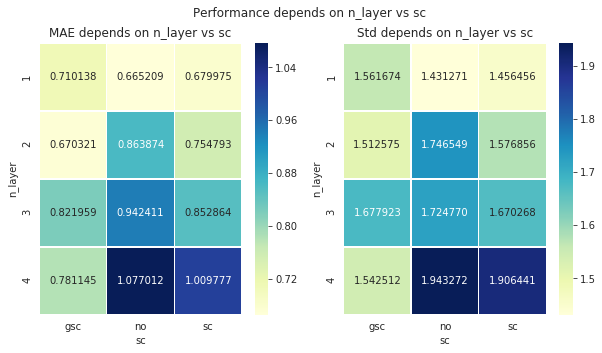

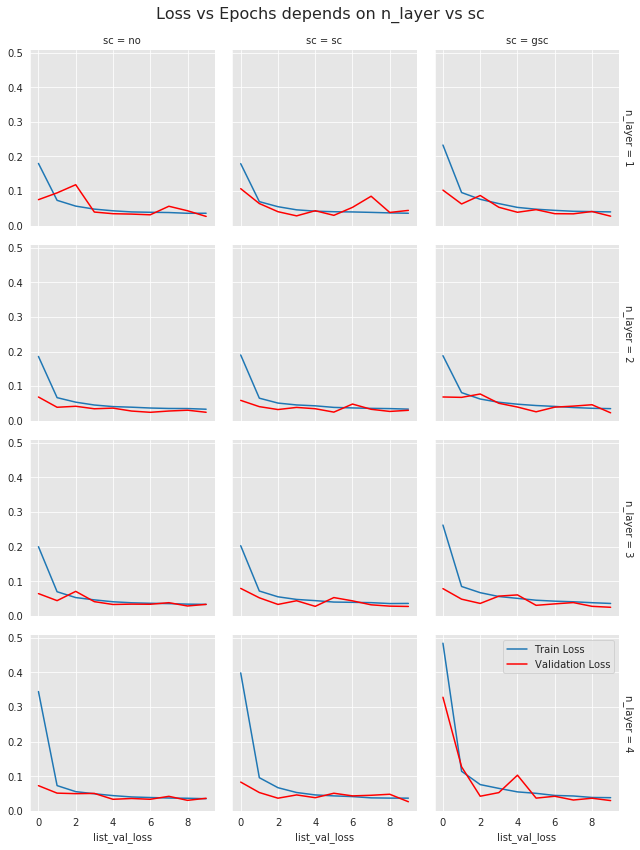

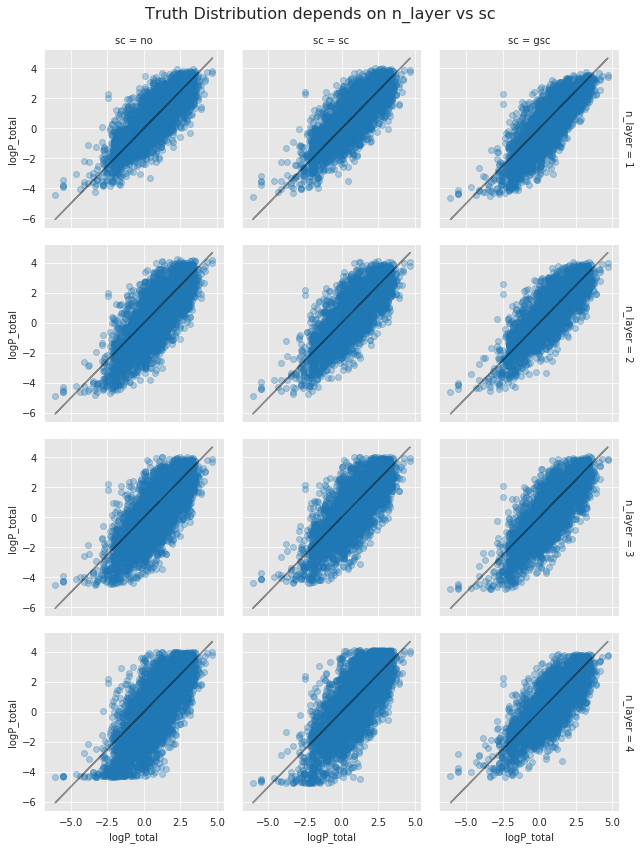

In [68]:
#df_result = pd.read_json('n_layer vs sc.JSON', orient='table')

plot_performance(df_result, 'n_layer', 'sc')
plot_loss(df_result, 'n_layer', 'sc')
plot_distribution(df_result, 'n_layer', 'sc')